In [10]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as sm


In [11]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
df = pd.read_csv("train.csv")
df.columns

Index(['Unnamed: 0', 'id', 'stmt_date', 'HQ_city', 'legal_struct',
       'ateco_sector', 'def_date', 'fs_year', 'asst_intang_fixed',
       'asst_tang_fixed', 'asst_fixed_fin', 'asst_current', 'AR',
       'cash_and_equiv', 'asst_tot', 'eqty_tot', 'eqty_corp_family_tot',
       'liab_lt', 'liab_lt_emp', 'debt_bank_st', 'debt_bank_lt', 'debt_fin_st',
       'debt_fin_lt', 'AP_st', 'AP_lt', 'debt_st', 'debt_lt', 'rev_operating',
       'COGS', 'prof_operations', 'goodwill', 'inc_financing', 'exp_financing',
       'prof_financing', 'inc_extraord', 'taxes', 'profit', 'days_rec',
       'ebitda', 'roa', 'roe', 'wc_net', 'margin_fin', 'cf_operations'],
      dtype='object')

In [13]:
print("Size of Dataset:", df.shape)
print("Features:\n", list(df.columns))

Size of Dataset: (1023552, 44)
Features:
 ['Unnamed: 0', 'id', 'stmt_date', 'HQ_city', 'legal_struct', 'ateco_sector', 'def_date', 'fs_year', 'asst_intang_fixed', 'asst_tang_fixed', 'asst_fixed_fin', 'asst_current', 'AR', 'cash_and_equiv', 'asst_tot', 'eqty_tot', 'eqty_corp_family_tot', 'liab_lt', 'liab_lt_emp', 'debt_bank_st', 'debt_bank_lt', 'debt_fin_st', 'debt_fin_lt', 'AP_st', 'AP_lt', 'debt_st', 'debt_lt', 'rev_operating', 'COGS', 'prof_operations', 'goodwill', 'inc_financing', 'exp_financing', 'prof_financing', 'inc_extraord', 'taxes', 'profit', 'days_rec', 'ebitda', 'roa', 'roe', 'wc_net', 'margin_fin', 'cf_operations']


In [14]:
print('\n Unique default dates: ', df.def_date.unique(), '\n Unique fiscal years: ', df.fs_year.unique(), 
      '\n Unique statement dates: ', df.stmt_date.unique())


 Unique default dates:  ['NaT' '31/10/2008' '28/07/2008' ... '27/07/2013' '01/11/2013'
 '03/01/2013'] 
 Unique fiscal years:  [2011 2008 2009 2012 2007 2010] 
 Unique statement dates:  ['2011-12-31' '2008-12-31' '2009-12-31' '2012-12-31' '2007-12-31'
 '2010-12-31']


## Distribution of null values

In [15]:
df.isnull().sum() * 100 / len(df)

Unnamed: 0                0.000000
id                        0.000000
stmt_date                 0.000000
HQ_city                   0.027063
legal_struct              0.000000
ateco_sector              0.000000
def_date                  0.000000
fs_year                   0.000000
asst_intang_fixed         0.015827
asst_tang_fixed           0.010063
asst_fixed_fin            0.023155
asst_current              0.000098
AR                        0.001172
cash_and_equiv            0.001661
asst_tot                  0.000000
eqty_tot                  0.000098
eqty_corp_family_tot    100.000000
liab_lt                   0.028724
liab_lt_emp               0.015827
debt_bank_st             11.853917
debt_bank_lt              8.887775
debt_fin_st              11.994701
debt_fin_lt               8.994951
AP_st                    11.785918
AP_lt                     9.012146
debt_st                   0.000488
debt_lt                   0.015143
rev_operating             0.017000
COGS                

## Distribution of Legal Structure

<Axes: xlabel='legal_struct'>

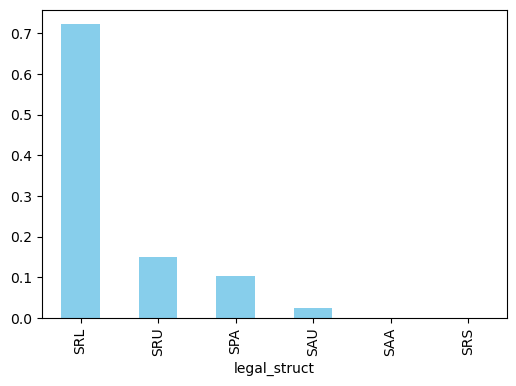

In [16]:
legal_struct_distribution = df['legal_struct'].value_counts(normalize=True)
plt.figure(figsize=(6, 4))
legal_struct_distribution.plot(kind='bar', color='skyblue')

## Distribution of Industry Sector

<Axes: xlabel='ateco_sector'>

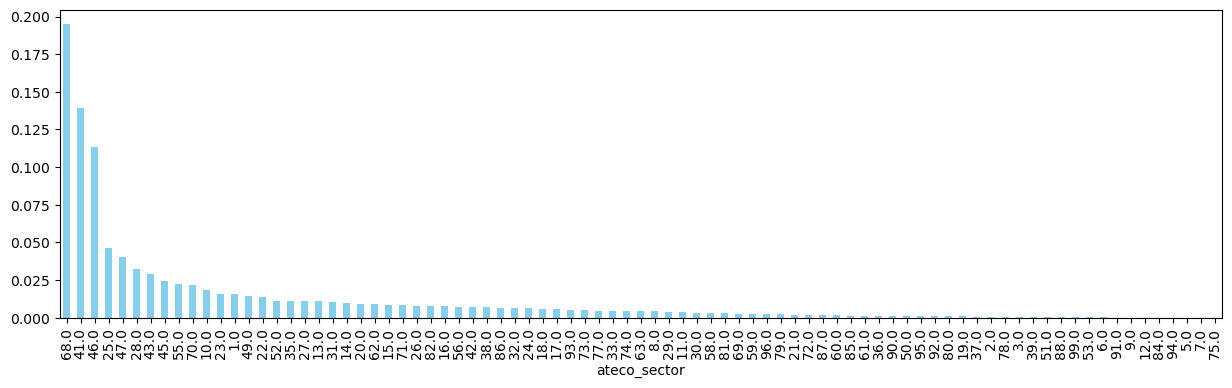

In [17]:
ateco_sector_distribution = df['ateco_sector'].value_counts(normalize=True)
plt.figure(figsize=(15, 4))
ateco_sector_distribution.plot(kind='bar', color='skyblue')

## Percentage of Firms with Taxes Liability

In [18]:
# Calculate average taxes and extraordinary income, then merge them into a single DataFrame
taxes = (
    df.groupby('id')[['taxes', 'inc_extraord']]
    .mean()
    .rename(columns={'taxes': 'avg_taxes', 'inc_extraord': 'avg_ext_inc'})
    .reset_index()
)

# Calculate the percentage of firms with and without tax liability
num_unique_firms = taxes['id'].nunique()
percent_no_tax_liability = (taxes['avg_taxes'] <= 0).mean() * 100
percent_with_tax_liability = (taxes['avg_taxes'] > 0).mean() * 100

# Print the results
print(f'% of unique firms with no tax liability: {percent_no_tax_liability:.2f}')
print(f'% of unique firms with tax liability: {percent_with_tax_liability:.2f}')

% of unique firms with no tax liability: 31.31
% of unique firms with tax liability: 68.69


## Percentage of Default vs. Non-Defaulted Records:


In [19]:
percent_default = np.round(((len(df[df['def_date'] != 'NaT']) / len(df)) * 100),2)

print("% Nondefault:", 100 - percent_default)
print("% Default:",  percent_default)

% Nondefault: 94.59
% Default: 5.41


## Percentage of Default vs. Non-Defaulted Firms

In [20]:
percent_default_firm = np.round(((df[df['def_date']!= 'NaT']['id'].nunique() / df['id'].nunique()) * 100),2)
print("% Nondefault:", 100 - percent_default_firm)
print("% Default:",  percent_default_firm)

% Nondefault: 91.74
% Default: 8.26


## Distribution of Defaulted Firms in Each Year

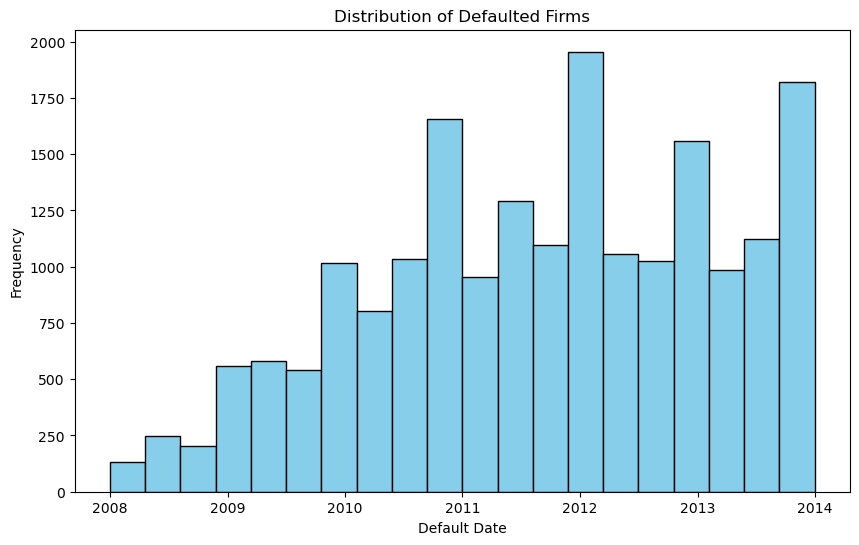

In [21]:
defaulted = df[df['def_date'].notna()].drop_duplicates(subset='id')

# Convert 'def_date' to datetime and plot as a histogram
plt.figure(figsize=(10, 6))
plt.hist(pd.to_datetime(defaulted['def_date'], errors='coerce'), bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Defaulted Firms")
plt.xlabel("Default Date")
plt.ylabel("Frequency")
plt.show()

## Fill Missing Values

In [22]:
# df['roa'] = df['roa'].fillna(df['profit'] / df['asst_tot'])

# df['exp_financing'] = df['exp_financing'].fillna(df['inc_financing'] - df['prof_financing'])
# df['eqty_tot'] = df['eqty_tot'].fillna(df['asst_tot'] - (df['liab_lt'] + df['debt_bank_st'] + df['debt_bank_lt'] +
                                        # df['debt_fin_st'] + df['debt_fin_lt'] + df['AP_st'] +
                                        # df['AP_lt']))
df['roe'] = df['roa'] * df['asst_tot']/df['eqty_tot']

## Feature Selection

Size: 
1. total asset 

Leverage: <br>
1. total debt / total asset = (total asset - total equity) / total asset  
2. total debt / total equity 
3. total debt / EBITDA


Profitability: <br>
1. ROA 
2. operating profit margin = operating profit/ operating revenue 
3. ROE
4. earning power = EBITDA/total asset 


Liquidity: <br>
1. cash & equivalents / total asset
2. current ratio = total asset/(total asset - Net working capital )
3. cash ration = cash & equivalents/(total asset - Net working capital )

Debt coverage: 
1. operating cash flow / financial expense


In [23]:
df['def_date'] = pd.to_datetime(df['def_date'], dayfirst=True)
df['stmt_date'] = pd.to_datetime(df['stmt_date'])
# size
df['asst_tot']
# leverage
df['td_ta'] = (df['asst_tot'] - df['eqty_tot']) / df['asst_tot']
df['td_te'] = (df['asst_tot'] - df['eqty_tot']) / df['eqty_tot']
df['td_ebitda'] = (df['asst_tot'] - df['eqty_tot']) / df['ebitda']
# profitability
df['roa']
df['roe']
df['operating_margin'] = df['prof_operations'] / df['rev_operating']
df['earning_power'] = df['ebitda'] / df['asst_tot']
# liquidity
df['Liquidity'] = df['cash_and_equiv'] / (df['asst_tot'])
df['current_ratio'] = df['asst_tot']/(df['asst_tot'] - df['wc_net'])
df['cash_ratio'] = df['cash_and_equiv'] / (df['asst_tot'] - df['wc_net'])
# debt coverage
df['Debt_coverage'] = df['cf_operations'] / df['exp_financing']

In [24]:
train = df[['id', 'stmt_date', 'fs_year', 'def_date', 'legal_struct', 'ateco_sector', 
             'roa','roe','operating_margin','earning_power','td_ta', 'td_te',
            'td_ebitda','current_ratio','cash_ratio','Debt_coverage', 'Liquidity', 'asst_tot']].copy()
train['default_year'] = pd.to_datetime(train['def_date'], format="%d/%m/%Y", errors='coerce').dt.year
train['target'] = ((train['default_year'].notna()) & (train['fs_year'] + 1 >= train['default_year'])).astype(int)

# Rename columns for clarity
train.head(20)

,id,stmt_date,fs_year,def_date,legal_struct,ateco_sector,roa,roe,operating_margin,earning_power,td_ta,td_te,td_ebitda,current_ratio,cash_ratio,Debt_coverage,Liquidity,asst_tot,default_year,target
0,520288,2011-12-31,2011,NaT,SRL,14.0,-3.81,-25.580351,-0.137751,0.003245,0.851058,5.714003,262.259892,1.342086,0.001436,-0.054598,0.001070,1946940.0,NaN,0
1,520288,2008-12-31,2008,NaT,SRL,14.0,-2.76,153.609510,-0.059348,0.022186,1.017968,-56.655620,45.883332,1.049486,0.002697,-0.077998,0.002570,2077346.0,NaN,0
2,520288,2009-12-31,2009,NaT,SRL,14.0,-2.17,94.987629,-0.067053,0.034218,1.022845,-44.773101,29.891778,0.903651,0.004798,0.925622,0.005310,1975874.0,NaN,0
3,520288,2012-12-31,2012,NaT,SRL,14.0,-12.99,-620.726060,-0.760990,-0.086219,0.979073,46.784916,-11.355652,1.244448,0.004351,-12.015864,0.003496,1872882.0,NaN,0
4,520288,2007-12-31,2007,NaT,SRL,14.0,6.20,156.559469,0.053771,0.086517,0.960398,24.251527,11.100627,0.848041,0.006845,5.898666,0.008071,1769122.0,NaN,0
5,520288,2010-12-31,2010,NaT,SRL,14.0,-4.08,-20.853409,-0.137288,0.002094,0.804349,4.111130,384.176944,1.266042,0.004355,-0.134038,0.003440,1897604.0,NaN,0
6,1400357,2010-12-31,2010,NaT,SRL,49.0,4.25,9.885481,0.052602,0.066930,0.570077,1.325995,8.517525,1.122364,0.270681,11.880414,0.241171,1668404.0,NaN,0
7,1400357,2009-12-31,2009,NaT,SRL,49.0,2.11,4.881078,0.031545,0.045413,0.567718,1.313307,12.501098,1.129348,0.187489,3.206344,0.166015,1554318.0,NaN,0
8,1400357,2008-12-31,2008,NaT,SRL,49.0,-0.26,-0.549602,-0.080949,0.000654,0.526931,1.113855,805.619675,1.203840,0.228163,-11.498609,0.189529,1507487.0,NaN,0
9,1400357,2011-12-31,2011,NaT,SRL,49.0,5.47,11.058172,0.069453,0.092900,0.505343,1.021604,5.439631,1.023171,0.169036,12.467527,0.165208,1571061.0,NaN,0


In [25]:
train.isnull().sum() * 100 / len(train)

id                   0.000000
stmt_date            0.000000
fs_year              0.000000
def_date            94.585131
legal_struct         0.000000
ateco_sector         0.000000
roa                  0.002638
roe                  0.002736
operating_margin     0.062527
earning_power        0.007914
td_ta                0.000098
td_te                0.000098
td_ebitda            0.009575
current_ratio        0.000586
cash_ratio           0.003908
Debt_coverage        0.082360
Liquidity            0.001661
asst_tot             0.000000
default_year        94.585131
target               0.000000
dtype: float64

## Univariate Analysis

Results: <br>
liquidity: current_ratio <br>
leverage: td/ta <br>
profitability: roa <br>
size: total asset <br>
debt coverage: debt coverage



In [26]:
def univariate_analysis(df,features):
    results = {}
    for feature in features:
        df_subset = df[['target','fs_year', feature]]
        df_subset = df_subset.replace([float('inf'), -float('inf')], float('nan')).dropna()
        df_train = df_subset[df_subset['fs_year'] <= 2010]
        df_test = df_subset[df_subset['fs_year'] > 2010]
        # print(df_train)
        formula = f"target ~ {feature}"
        model = sm.logit(formula=formula, data=df_train).fit()

        X_test = df_test[[feature]]
        y_test = df_test['target']
        # Standardize features
        # scaler = StandardScaler()
        # X_train = scaler.fit_transform(X_train)
        # X_test = scaler.transform(X_test)
        # X_test = sm.add_constant(X_test)
        prob = model.predict(X_test)

        roc_auc = roc_auc_score(y_test, prob)
        results[feature] = {
            'model_summary': model.summary(),
            'roc_auc_score': roc_auc
        }
    
    return results


In [27]:
# liquidity
liquidity = ['Liquidity','current_ratio','cash_ratio']
analysis_results = univariate_analysis(train, liquidity)

for feature in liquidity:
    print(f"Feature: {feature}")
    print(analysis_results[feature]['model_summary'])
    print(f"ROC AUC Score: {analysis_results[feature]['roc_auc_score']}\n")
   

Optimization terminated successfully.
         Current function value: 0.059560
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.059598
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.059599
         Iterations 9
Feature: Liquidity
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:               652925
Model:                          Logit   Df Residuals:                   652923
Method:                           MLE   Df Model:                            1
Date:                Sun, 10 Nov 2024   Pseudo R-squ.:               0.0005590
Time:                        17:01:57   Log-Likelihood:                -38888.
converged:                       True   LL-Null:                       -38910.
Covariance Type:            nonrobust   LLR p-value:                 4.233e-11
                 coef    std err          

In [28]:
# leverage
leverage = ['td_ta','td_te','td_ebitda']
analysis_results = univariate_analysis(train, leverage)

for feature in leverage:
    print(f"Feature: {feature}")
    print(analysis_results[feature]['model_summary'])
    print(f"ROC AUC Score: {analysis_results[feature]['roc_auc_score']}\n")

Optimization terminated successfully.
         Current function value: 0.056330
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.059579
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.059530
         Iterations 9
Feature: td_ta
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:               652940
Model:                          Logit   Df Residuals:                   652938
Method:                           MLE   Df Model:                            1
Date:                Sun, 10 Nov 2024   Pseudo R-squ.:                 0.05475
Time:                        17:02:02   Log-Likelihood:                -36780.
converged:                       True   LL-Null:                       -38910.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z    

In [29]:
# profitability
profitability = ['roa','operating_margin','earning_power','roe']
analysis_results = univariate_analysis(train, profitability)

for feature in profitability:
    print(f"Feature: {feature}")
    print(analysis_results[feature]['model_summary'])
    print(f"ROC AUC Score: {analysis_results[feature]['roc_auc_score']}\n")

Optimization terminated successfully.
         Current function value: 0.053270
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.059015
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.059579
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.059581
         Iterations 9
Feature: roa
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:               652915
Model:                          Logit   Df Residuals:                   652913
Method:                           MLE   Df Model:                            1
Date:                Sun, 10 Nov 2024   Pseudo R-squ.:                  0.1061
Time:                        17:02:07   Log-Likelihood:                -34781.
converged:                       True   LL-Null:                       -38910.
Covariance Type:          

## Final dataset we used with selected features

In [30]:
clean = train[['id','fs_year','def_date', 'target','roa','td_ta','current_ratio','Debt_coverage', 'asst_tot']].copy()
clean = clean.replace([float('inf'), -float('inf')], float('nan')).dropna()
clean     

,id,fs_year,def_date,target,roa,td_ta,current_ratio,Debt_coverage,asst_tot
957960,40230625,2007,2008-10-31,1,-0.88,0.987200,1.030552,-0.518981,7012670.0
957961,40750382,2007,2008-07-28,1,-1.96,1.023139,0.789383,-1.009355,8243950.0
957962,66210931,2007,2008-12-22,1,-3.12,0.994626,0.775622,-1.455152,2053551.0
957963,75040931,2007,2008-11-19,1,-14.12,0.975860,1.544071,-2.729320,7209854.0
957964,85280527,2007,2008-05-15,1,-7.35,0.034132,1.003858,-12.193627,2574065.0
...,...,...,...,...,...,...,...,...,...
1013379,96026470060,2009,2013-01-14,0,-5.49,0.817558,1.169782,0.615376,19227503.0
1013380,96026470060,2008,2013-01-14,0,-19.93,0.930622,0.997841,-6.473819,15749504.0
1013381,96026470060,2010,2013-01-14,0,1.54,0.863476,1.070188,10.966388,30590963.0
1013382,96026470060,2011,2013-01-14,0,-1.34,0.915672,1.033594,0.635739,37635198.0


### Log transformation and standardization

<Figure size 1500x1000 with 0 Axes>

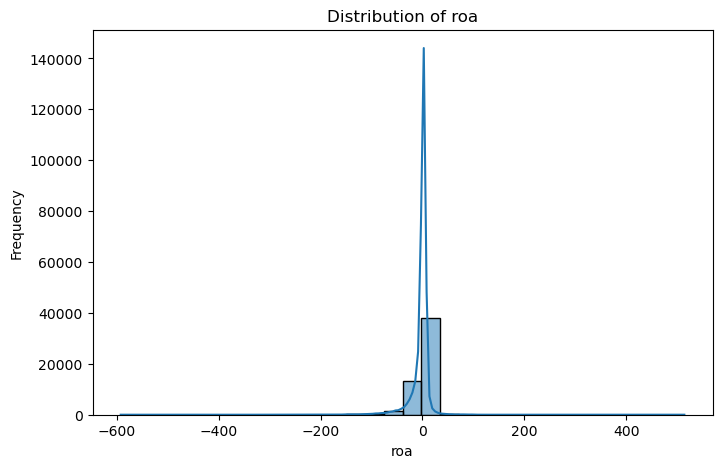

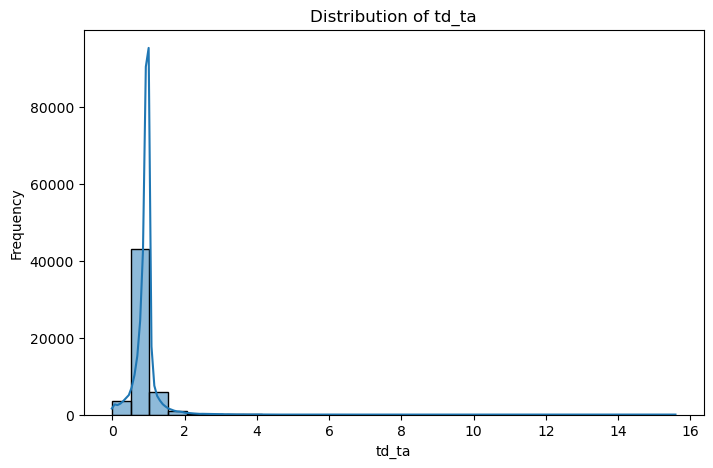

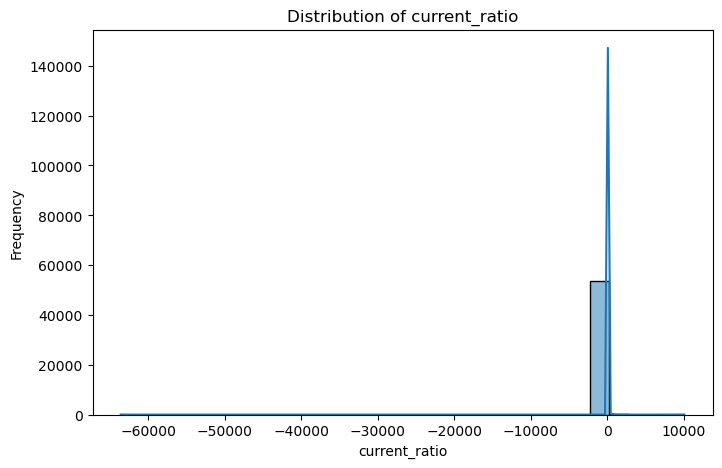

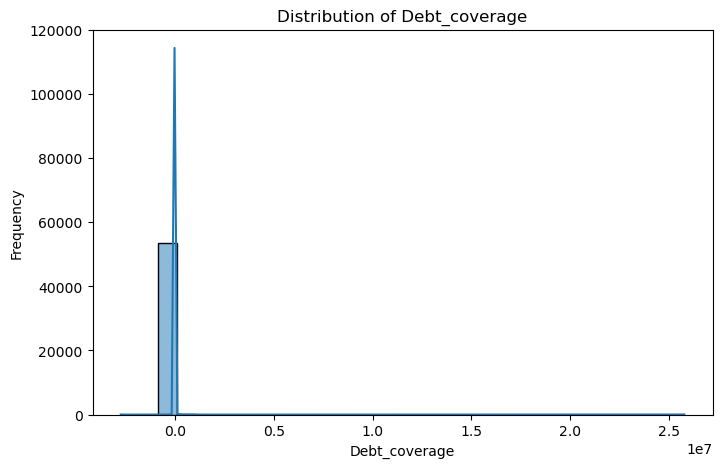

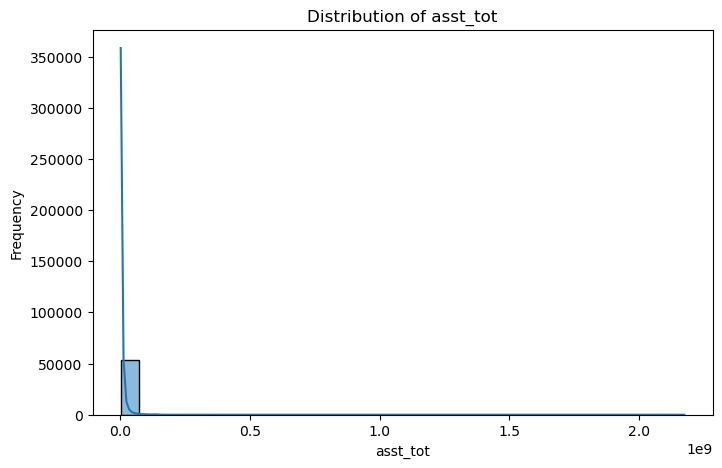

In [40]:
# List of the variables to plot
clean_var = clean[['roa','td_ta','current_ratio','Debt_coverage', 'asst_tot']]

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Plot histograms and density plots
for column in clean_var.columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(clean_var[column], kde=True, bins=30)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()


In [41]:
# List of columns to check
columns_to_check = ['roa','td_ta','current_ratio','Debt_coverage', 'asst_tot']

# Check for negative values or zeros
for column in columns_to_check:
    has_negative = (clean[column] < 0).any()
    has_zeros = (clean[column] == 0).any()
    print(f"Column '{column}':")
    print(f"  Contains negative values: {has_negative}")
    print(f"  Contains zeros: {has_zeros}")
    print()


Column 'roa':
  Contains negative values: True
  Contains zeros: True

Column 'td_ta':
  Contains negative values: True
  Contains zeros: True

Column 'current_ratio':
  Contains negative values: True
  Contains zeros: False

Column 'Debt_coverage':
  Contains negative values: True
  Contains zeros: True

Column 'asst_tot':
  Contains negative values: False
  Contains zeros: False



In [45]:
# Log transformation for total assets (add 1 if there's a possibility of zero values)
clean['asst_tot_log'] = np.log(clean['asst_tot'])

# Select columns for standardization
columns_to_standardize = ['roa','td_ta','current_ratio','Debt_coverage', 'asst_tot_log']

# Standardize all selected variables
scaler = StandardScaler()
clean[columns_to_standardize] = scaler.fit_transform(clean[columns_to_standardize])

# Display the transformed DataFrame
print(clean[columns_to_standardize].head())


             roa     td_ta  current_ratio  Debt_coverage  asst_tot_log
957960  0.116001  0.202207      -0.004783      -0.005296      0.619472
957961  0.067133  0.307184      -0.005615      -0.005300      0.806857
957962  0.014646  0.223899      -0.005662      -0.005304     -0.803222
957963 -0.483082  0.169082      -0.003011      -0.005314      0.651595
957964 -0.176753 -2.581704      -0.004875      -0.005393     -0.541520


In [46]:
clean.head()

,id,fs_year,def_date,target,roa,td_ta,current_ratio,Debt_coverage,asst_tot,asst_tot_log
957960,40230625,2007,2008-10-31,1,0.116001,0.202207,-0.004783,-0.005296,7012670.0,0.619472
957961,40750382,2007,2008-07-28,1,0.067133,0.307184,-0.005615,-0.005300,8243950.0,0.806857
957962,66210931,2007,2008-12-22,1,0.014646,0.223899,-0.005662,-0.005304,2053551.0,-0.803222
957963,75040931,2007,2008-11-19,1,-0.483082,0.169082,-0.003011,-0.005314,7209854.0,0.651595
957964,85280527,2007,2008-05-15,1,-0.176753,-2.581704,-0.004875,-0.005393,2574065.0,-0.541520


In [31]:
clean.iloc[: , -5:].describe()[1:].corr()


,roa,td_ta,current_ratio,Debt_coverage,asst_tot
roa,1.000000,0.754647,0.883987,0.787818,0.721873
td_ta,0.754647,1.000000,0.362829,0.997854,0.997618
current_ratio,0.883987,0.362829,1.000000,0.409185,0.315159
Debt_coverage,0.787818,0.997854,0.409185,1.000000,0.994899
asst_tot,0.721873,0.997618,0.315159,0.994899,1.000000


## Check Multicollinearity: 

	VIF = 1: No multicollinearity (the variable is not correlated with other predictors).

	VIF between 1 and 5: Low to moderate multicollinearity (acceptable in most cases).

	VIF above 5: Moderate to high multicollinearity (might need closer examination, especially in sensitive models).

	VIF above 10: High multicollinearity (often considered problematic and typically indicates that you should consider removing or transforming the variable).

In [47]:


# Assuming `train` is your DataFrame containing the columns you want to check for multicollinearity
# Select only the numerical features for VIF calculation
features = clean[['roa','td_ta','current_ratio','Debt_coverage', 'asst_tot_log']]

# Add a constant to the model for VIF calculation
X = add_constant(features)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF data
print(vif_data)

         Feature       VIF
0          const  1.000000
1            roa  1.399630
2          td_ta  1.403406
3  current_ratio  1.000042
4  Debt_coverage  1.000389
5   asst_tot_log  1.004195


## A Logit Model With Features

In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler


df_train = clean[clean['fs_year'] <= 2010]
df_test = clean[clean['fs_year'] > 2010]
formula = f"target ~ roa + td_ta + current_ratio + Debt_coverage + asst_tot_log"
model = sm.logit(formula=formula, data=df_train).fit()

X_test = df_test[['roa','td_ta','current_ratio','Debt_coverage', 'asst_tot_log']]
y_test = df_test['target']
prob = model.predict(X_test)
roc_auc = roc_auc_score(y_test, prob)
print(model.summary())
print(f"ROC AUC: {roc_auc:.4f}")

Optimization terminated successfully.
         Current function value: 0.372342
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                46522
Model:                          Logit   Df Residuals:                    46516
Method:                           MLE   Df Model:                            5
Date:                Sun, 10 Nov 2024   Pseudo R-squ.:                  0.1036
Time:                        17:26:31   Log-Likelihood:                -17322.
converged:                       True   LL-Null:                       -19323.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.8256      0.014   -129.336      0.000      -1.853      -1.798
roa              -0.